In [27]:
import preprocessing as pp
import detection
import measurement

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

import re

### GLOBAL FLAGS ###
DO_MEAS = False

# 0. Helper functions

In [28]:
def draw_lines_circles(img, lines, circles, thickness=2):

    base_n_shapes = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB)

    # Draw lines
    if lines:   # if lines is not empty
        for (x1, y1, x2, y2) in lines:
            cv2.line(base_n_shapes, (x1, y1), (x2, y2), (0, 255, 0), thickness)
        for (x1, y1, x2, y2) in lines:
            cv2.circle(base_n_shapes, (x1, y1), 2, (0, 0, 255), thickness)
            cv2.circle(base_n_shapes, (x2, y2), 2, (0, 0, 255), thickness)

    # Draw circles
    print(circles)
    if circles:     # if circles is not empty
        for (x, y, r) in circles:
            cv2.circle(base_n_shapes, (x, y), r, (0, 255, 0), thickness)
            cv2.circle(base_n_shapes, (x, y), 2, (0, 0, 255), thickness)

    return base_n_shapes



# 1. Define version of functions to use (for pp, detection, filtration)

In [29]:
f_get_edges = pp.get_edges
# f_get_edges = pp.get_edges_2

f_find_lines = detection.find_lines_HT
f_find_circles = detection.find_circles_HT
# f_find_circles = detection.find_circles

f_filter_lines = detection.filter_lines
f_filter_circles = detection.filter_circles

# 2. Specify, load, & display test images to use

Base path: c:\Users\jtyzhang\Desktop\jtyzhang\EECS442\EECS442_Final_Project


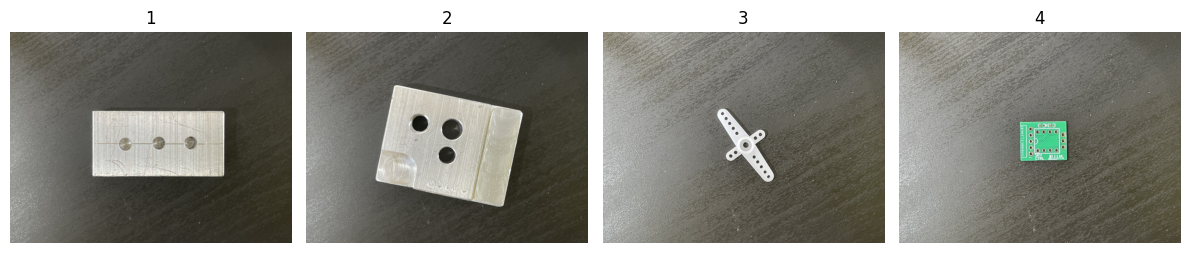

In [30]:
base_path = os.getcwd()
print("Base path:", base_path)
files = []

# parts_path = os.path.join(base_path, "data", "physical parts")
# files.append( os.path.join(parts_path, "Basic II base part.jpg") )
# files.append( os.path.join(parts_path, "mill part 2.jpeg") )
# files.append( os.path.join(parts_path, "servo mount 1.jpeg") )
# files.append( os.path.join(parts_path, "small PCB 2.jpeg") )

# parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in")
# img11 = os.path.join(parts_path, "Basic II base part 2.jpeg")
# img22 = os.path.join(parts_path, "mill part 2.jpeg")
# img33 = os.path.join(parts_path, "servo mount 1.jpeg")
# img44 = os.path.join(parts_path, "small PCB 2.jpeg")


parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in blk")
# files.append( os.path.join(parts_path, "Basic II base part 1 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "Basic II base part 2 thk0.50 r0.09375.jpeg") )
files.append( os.path.join(parts_path, "mill part 1 thk0.50 r0.125 r0.15625.jpeg") )
files.append( os.path.join(parts_path, "servo mount 1 thk0.122 r0.03125.jpeg") )
files.append( os.path.join(parts_path, "small PCB 2 thk0.06 r0.03125.jpeg") )

titles = [str(i) for i in range(1, len(files)+1)]

imgs = detection.show_images_from_files(files, titles)

# 3. Pass each image through f_get_edges(); extract result & intermediate images
Moved to Section 5 to plot full results and save run time

In [31]:
# img_results = []
# for img in imgs:
#     # find edges on original image
#     edges, interms = f_get_edges(img, return_interm=True)

#     # find features & overlay them on edge map
#     # we can perform measurement on the following outputs 
#     lines = f_find_lines(edges)
#     circles = f_find_circles(edges)
#     img_lines = draw_lines_circles(edges, lines, [])
#     img_circles = draw_lines_circles(edges, [], circles)    

#     # doing measurement here
#     if DO_MEAS:
#         measured_lines = measurement.measure_line(lines, conversion_ratio=1.0)
#         measured_circles = measurement.measure_circle(circles, conversion_ratio=1.0)


#     # organize results
#     result = [img]
#     result.extend(interms)
#     result.append(edges)
#     result.append(img_lines)
#     result.append(img_circles)
#     # result.append(features)
    
#     # store results of this instance
#     img_results.append(result)

#     # display measurement results
#     if DO_MEAS:
#         out = measurement.draw_measurements(img, measured_lines, measured_circles)
#         plt.figure()
#         plt.imshow(out)

# 4. Plot all images in organized format

Moved to section 5 to plot full results & save run time

images (or different objects) listed along rows;
intermediate results of each object listed along columns

In [32]:
# figsize = (32,24)    # physical part images taken from iphone should be of shape 4:3
# cols = len(img_results)     # plot objects along cols
# rows = len(img_results[0])  # plot steps along rows

# plt.figure(figsize=figsize)
# i = 1
# for r in range(rows):
#     for obj in img_results:
#         plt.subplot(rows, cols, i)
#         rst = obj[r]
#         plt.imshow(rst)
#         plt.axis('off')
#         i += 1
# plt.tight_layout()
# plt.show()


# 5. Filtration: 12/2/2025

## Define filtration methods

In [33]:
# from sklearn.cluster import DBSCAN

# def filter_lines(lines, eps_pos=10.0, eps_len=20.0, eps_angle=0.1, min_samples=2):
#     if not lines:
#         return []

#     cpfs = []
#     for (x1, y1, x2, y2) in lines:
#         x0 = (x1 + x2) / 2.0
#         y0 = (y1 + y2) / 2.0
#         L  = math.hypot(x2 - x1, y2 - y1)
#         t  = math.atan2(y2 - y1, x2 - x1)
#         if t < 0:
#             t += math.pi
#         cpfs.append((x0, y0, L, t))

#     cpfs = np.array(cpfs, dtype=float)

#     # Scale features for DBSCAN
#     X = np.empty_like(cpfs)
#     X[:, 0] = cpfs[:, 0] / eps_pos
#     X[:, 1] = cpfs[:, 1] / eps_pos
#     X[:, 2] = cpfs[:, 2] / eps_len
#     X[:, 3] = cpfs[:, 3] / eps_angle

#     db = DBSCAN(eps=3.0, min_samples=min_samples)
#     labels = db.fit_predict(X)

#     filtered = []
#     unique_labels = set(labels)
#     for lbl in unique_labels:
#         if lbl == -1:
#             continue

#         cluster_cpfs = cpfs[labels == lbl]
#         if cluster_cpfs.size == 0:
#             continue

#         x0 = np.median(cluster_cpfs[:, 0])
#         y0 = np.median(cluster_cpfs[:, 1])
#         L  = np.max(cluster_cpfs[:, 2])
#         t  = np.median(cluster_cpfs[:, 3])

#         # Convert back to (x1, y1, x2, y2)
#         dx = (L / 2.0) * math.cos(t)
#         dy = (L / 2.0) * math.sin(t)

#         x1 = int(round(x0 - dx))
#         y1 = int(round(y0 - dy))
#         x2 = int(round(x0 + dx))
#         y2 = int(round(y0 + dy))

#         filtered.append((x1, y1, x2, y2))

#     return filtered


In [34]:
# PROBLEM TO ADDRESS: Get rid of small circles - They get high scores when they exist inside the gradient entirely

# def filter_circles(edges, circles, height, width,
#                    radial_tolerance=1, # Assumed thickness tolerance of an edge 
#                    grad_mag_thresh=6.0, # Magnitude threshold for gradient difference
#                    angle_cos_thresh=0.7, # Threshold from orthogonal to test 
#                    min_strength=0.2, # Minimum required strength to allow a cluster (0-1)
#                    num_samples=180): # Num point samples drawn along the cricle

#     canvas = np.zeros((height, width), dtype=np.uint8)

#     # Normalize circles to a Python list of tuples
#     if circles is None:
#         circles = []
#     elif isinstance(circles, np.ndarray):
#         circles = circles.tolist()

#     if hasattr(circles, '__len__') and len(circles) == 0:
#         return [], canvas

#     # Edge Gradients
#     gx = cv2.Sobel(edges, cv2.CV_32F, 1, 0, ksize=3)
#     gy = cv2.Sobel(edges, cv2.CV_32F, 0, 1, ksize=3)

#     circles = [(int(x), int(y), int(r)) for (x, y, r) in circles if r > 0]
#     n = len(circles)
#     if n == 0:
#         return [], canvas

#     # Group circles by containment w/ union find (borrowed implementation)

#     parent = list(range(n))

#     def find(i):
#         while parent[i] != i:
#             parent[i] = parent[parent[i]]
#             i = parent[i]
#         return i

#     def union(i, j):
#         ri, rj = find(i), find(j)
#         if ri != rj:
#             parent[rj] = ri

#     def contains(ci, cj):
#         xi, yi, ri = ci
#         xj, yj, rj = cj
#         dx = xj - xi
#         dy = yj - yi
#         d = math.hypot(dx, dy)
#         # return d + rj <= ri
#         return d <= ri

#     for i in range(n):
#         for j in range(i + 1, n):
#             ci = circles[i]
#             cj = circles[j]
#             if contains(ci, cj) or contains(cj, ci):
#                 union(i, j)

#     groups = {}
#     for i in range(n):
#         root = find(i)
#         groups.setdefault(root, []).append(i)

#     # Strength scoring using edge gradients
#     def circle_strength(circle):
#         x, y, r = circle
#         if r <= 0:
#             return 0.0

#         thetas = np.linspace(0, 2 * np.pi, num_samples, endpoint=False) # Sampling points
#         good = 0 # Num points that show gradient along drawn circle that is orthogonal to diameter
#         total = len(thetas)

#         h, w = edges.shape[:2]

#         for theta in thetas:
#             ct = math.cos(theta)
#             st = math.sin(theta)

#             for dr in range(-radial_tolerance, radial_tolerance + 1):
#                 rr = r + dr # Adding tolerance to assume some thickness in edge map / gradient
#                 if rr <= 0:
#                     continue
#                 # Get point x and point y given x,y radius and angle of approach 
#                 px = int(round(x + rr * ct)) 
#                 py = int(round(y + rr * st))

#                 if px < 0 or px >= w or py < 0 or py >= h:
#                     continue

#                 gx_val = float(gx[py, px])
#                 gy_val = float(gy[py, px])
#                 mag = math.hypot(gx_val, gy_val)

#                 if mag < grad_mag_thresh:
#                     continue

#                 # Normalize and get sobel vector (with some additional numbers to prevent divide by zero)
#                 ux, uy = gx_val / (mag + 1e-6), gy_val / (mag + 1e-6)

#                 # Get angle of vector w/ relation to circle with dot product
#                 cos_angle = abs(ux * ct + uy * st)

#                 if cos_angle >= angle_cos_thresh:
#                     good += 1
#                     break

#         return good / total

#     kept_circles = []

#     for root, idxs in groups.items():
#         # Evaluate strength for each circle in this group
#         best_circle = None
#         best_score = -1.0

#         for idx in idxs:
#             c = circles[idx]
#             score = circle_strength(c)
#             if score > best_score:
#                 best_score = score
#                 best_circle = c

#         # Keep strongest circle if it meets threshold
#         if best_circle is not None and best_score >= min_strength:
#             kept_circles.append(best_circle)

#     # Draw kept circles on canvas for debugging / visualization
#     for x, y, r in kept_circles:
#         cv2.circle(canvas, (x, y), r, 255, thickness=1)

#     return kept_circles, canvas


## Redo pipeline in Section 3,4 + filtration

In [35]:
img_results_filtered = []
i = 0

CROP = False
for img in imgs:
    if(CROP):
        img = pp.crop_largest_structure(img)[0]

    i += 1
    # find edges on original image
    edges, interms = f_get_edges(img, return_interm=True)

    # find features & overlay them on edge map
    # we can perform measurement on the following outputs 
    lines = f_find_lines(edges)
    circles = f_find_circles(edges)
    img_lines = draw_lines_circles(edges, lines, [], 5)
    img_circles = draw_lines_circles(edges, [], circles, 5)

    # FILTRATION 
    lines = f_filter_lines(lines)
    circles, fake_canvas = f_filter_circles(edges, circles, len(img), len(img[0]))
    print(f"Image {i} number of filtered lines: {len(lines)}")
    print(f"Image {i} number of filtered circles: {len(circles)}")


    img_lines_filtered = draw_lines_circles(edges, lines, [], 5)
    img_circles_filtered = draw_lines_circles(edges, [], circles, 5)
    # features = draw_lines_circles(edges, lines, circles)


    if DO_MEAS:
        measured_lines = measurement.measure_line(lines, conversion_ratio=1.0)
        measured_circles = measurement.measure_circle(circles, conversion_ratio=1.0)


    result = [img]
    result.extend(interms)
    result.append(edges)
    result.append(fake_canvas)
    result.append(img_lines)
    result.append(img_lines_filtered)
    result.append(img_circles)
    result.append(img_circles_filtered)
    # result.append(features)
    
    # store results of this instance
    img_results_filtered.append(result)

    # display measurement results
    if DO_MEAS:
        out = measurement.draw_measurements(img, measured_lines, measured_circles)
        plt.figure()
        plt.imshow(out)

[]
[(2078, 1586, 30), (2075, 1595, 28)]
Image 1 number of filtered lines: 4
Image 1 number of filtered circles: 1
[]
[(2078, 1586, 30)]
[]
[(2390, 2358, 32), (2385, 2368, 33), (2389, 2351, 31), (2390, 2367, 29), (2380, 2380, 30), (2333, 2410, 27)]
Image 2 number of filtered lines: 7
Image 2 number of filtered circles: 2
[]
[(2390, 2358, 32), (2333, 2410, 27)]
[]
[(1899, 1725, 38), (1826, 1775, 37), (2179, 1520, 37), (2253, 1468, 37), (1756, 1240, 36), (1913, 1449, 36), (1858, 1384, 36), (1865, 1377, 36), (1816, 1308, 36), (1808, 1310, 36), (2166, 1789, 35), (2159, 1791, 35), (2211, 1859, 35), (2266, 1928, 34), (1713, 1167, 35), (2315, 2007, 34), (2368, 2069, 33), (2161, 1798, 35), (2247, 1474, 36), (2044, 1603, 37), (1890, 1725, 36), (2058, 1619, 38), (2365, 2077, 31), (2249, 1448, 34), (2033, 1604, 38), (2057, 1628, 38), (2052, 1609, 36), (2043, 1641, 35), (2262, 1939, 31), (2272, 1453, 33), (2029, 1634, 37), (2217, 1865, 38), (2240, 1449, 35), (1909, 1456, 33), (1920, 1455, 39), (231

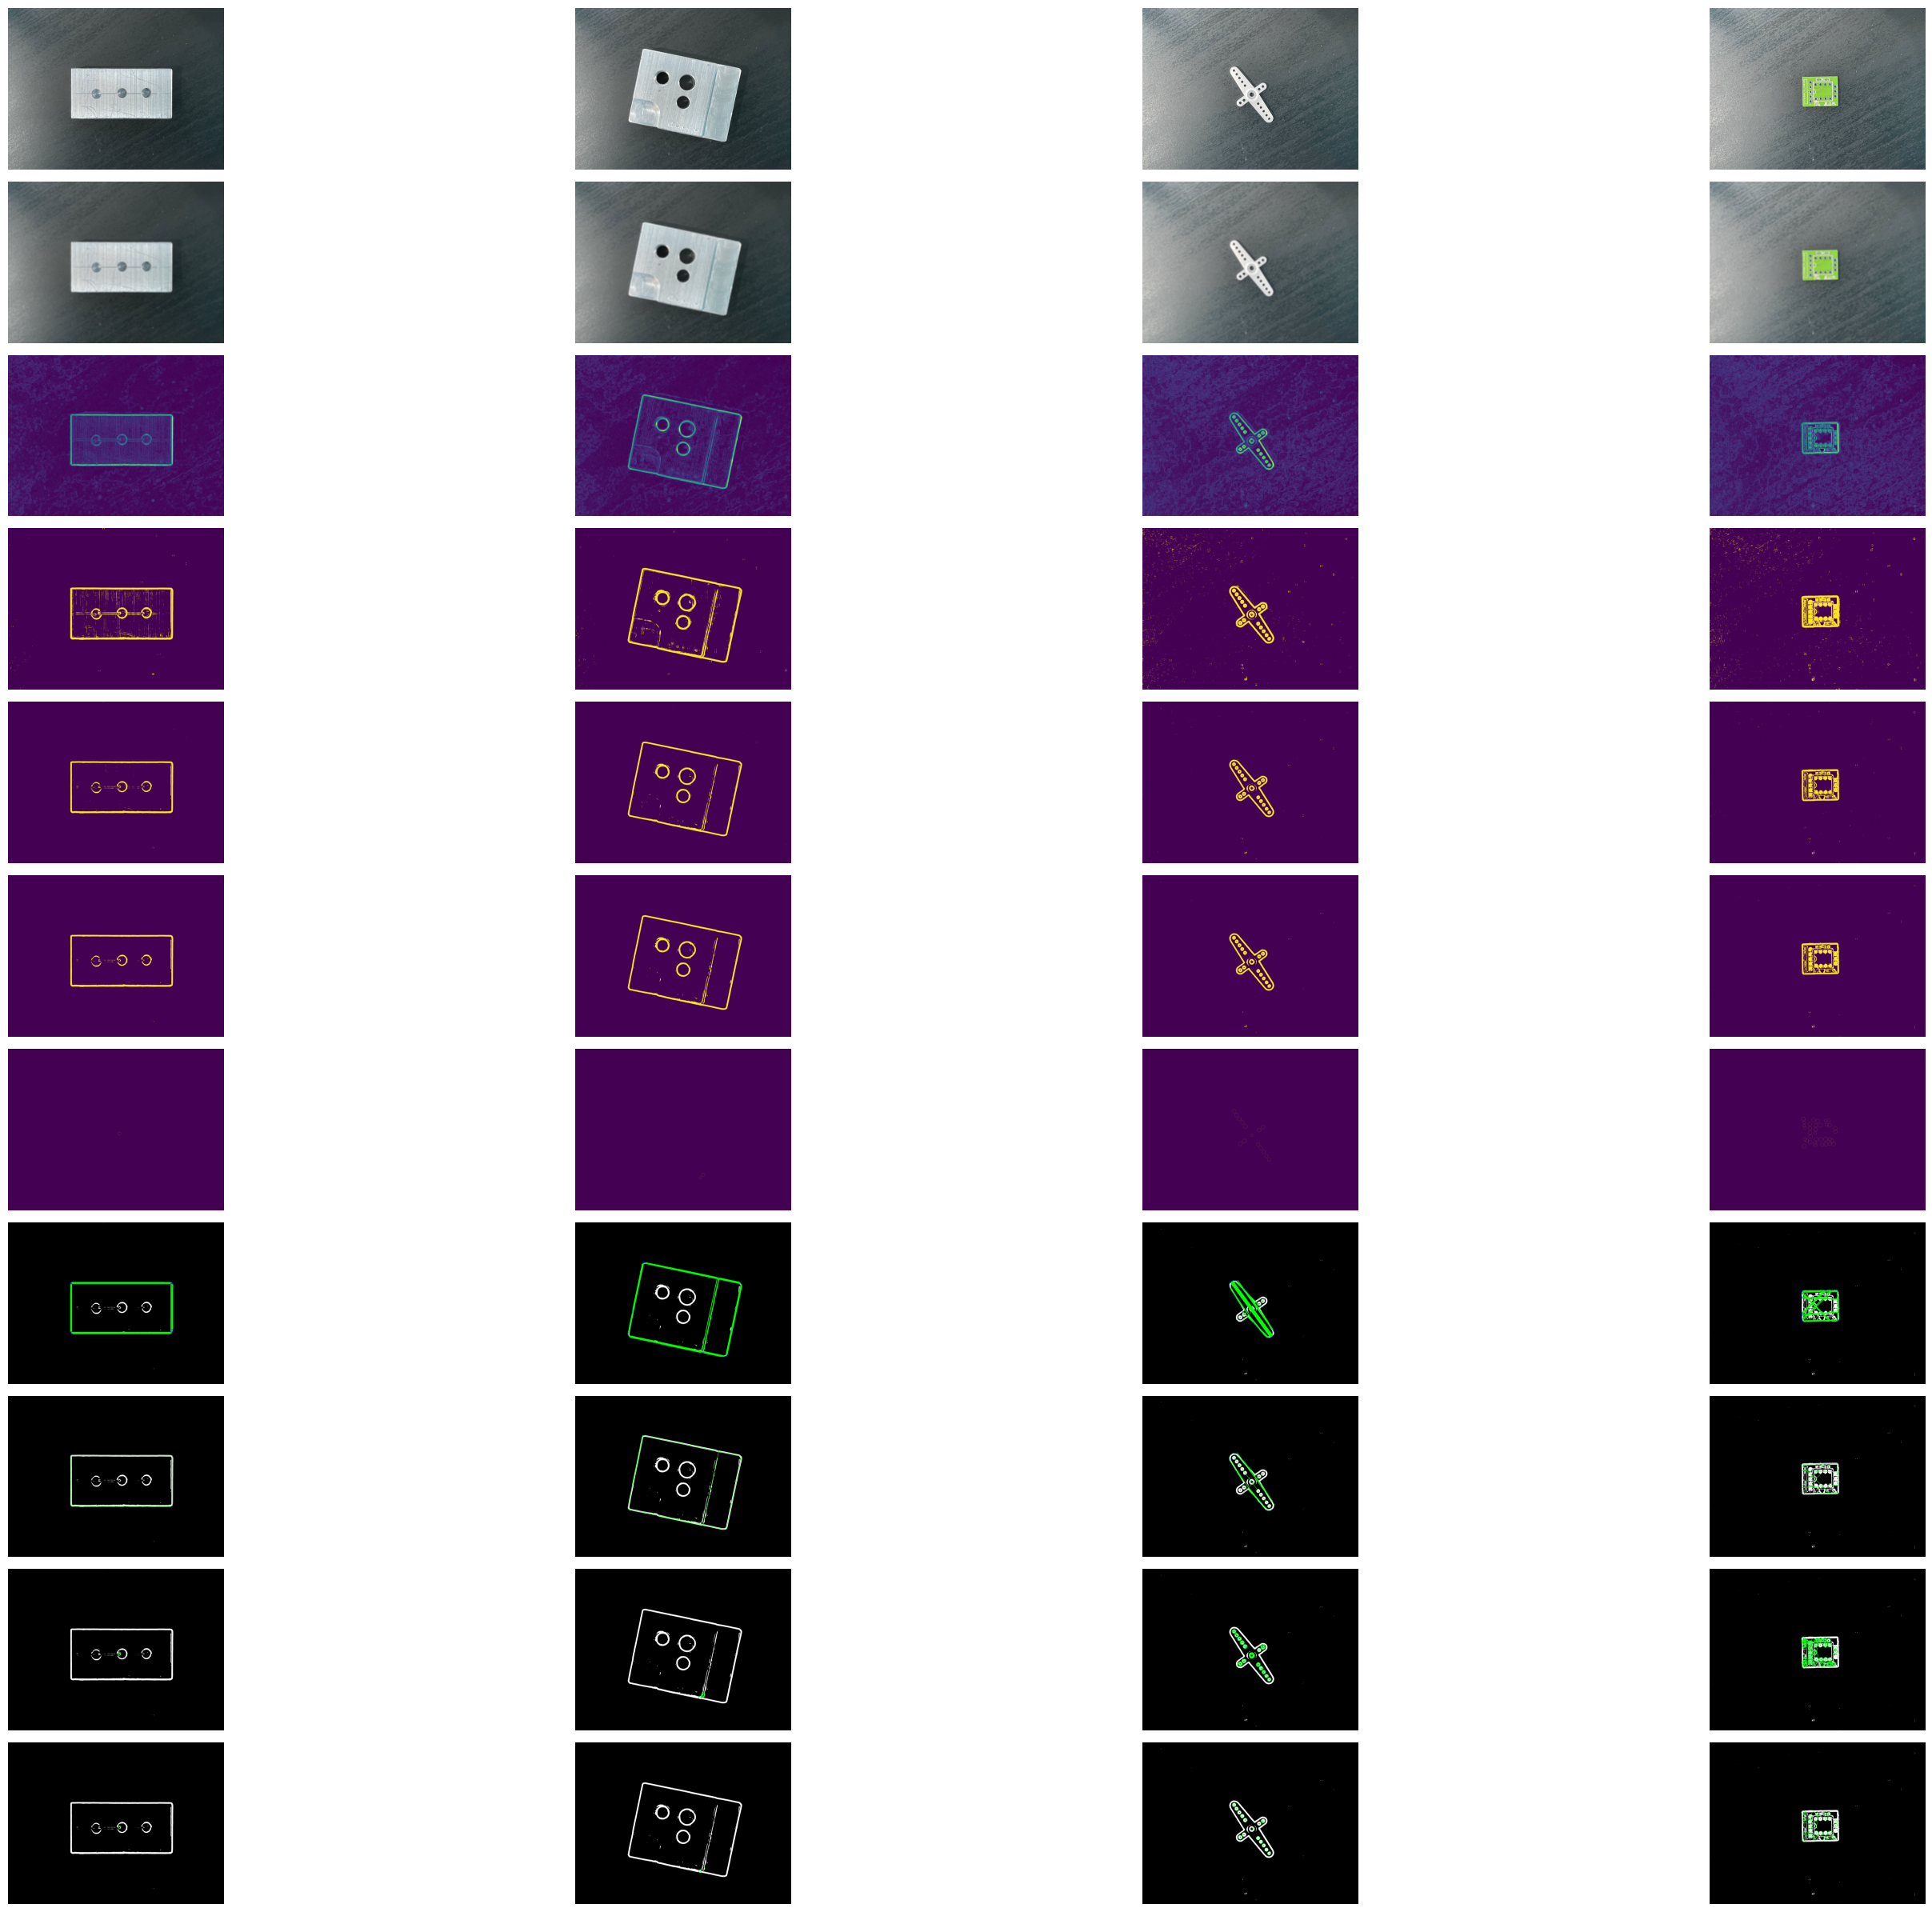

In [36]:
figsize = (32,24)    # physical part images taken from iphone should be of shape 4:3
cols = len(img_results_filtered)     # plot objects along cols
rows = len(img_results_filtered[0])  # plot steps along rows

plt.figure(figsize=figsize)
i = 1
for r in range(rows):
    for obj in img_results_filtered:
        plt.subplot(rows, cols, i)
        rst = obj[r]
        plt.imshow(rst)
        plt.axis('off')
        i += 1
plt.tight_layout()
plt.show()


# 6. Idea 2: Change circle detector to median the midpoints of clusters

Sub point: Get more accurate crop detector (or manually crop for now) to ensure noisy circles can be filtered out by minimum radius checks

# 7. End-to-End Pipeline



**Input:** ROI from a selected image

1. **Preprocessing (`pp.get_edges`)**
   - Compute `edges` and save intermediates for debugging.

2. **Detection**
   - `lines_raw = f_find_lines(edges)`
   - `circles_raw = f_find_circles(edges)`

3. **Filtration**
   - `lines_f = filter_lines(lines_raw)`
   - `circles_f, fake_canvas = filter_circles(edges, circles_raw, H, W)`

4. **Matching (`features.match_points_to_*`)**
   - `edge_points, _ = pp.get_edge_points(roi, edges, return_interm=True)`
   - `line_features = match_points_to_lines(lines_f, edge_points, ...)`
   - `circle_features = match_points_to_circles(circles_f, edge_points, ...)`

5. **Measurement (on feature objects)**
   - For each `line_feature`: `calc_dims()`, `calc_tols()`
   - For each `circle_feature`: `calc_dims()`, `calc_tols()`

6. **Output (visuals)**
   - Use `draw_lines_circles(edges, ...)` for consistent final lines/circles
   - Overlay measurement text on the ROI copy

In [37]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import main
import preprocessing as pp
import detection
from features import match_points_to_lines, match_points_to_circles, Line, Circle

def draw_lines_circles(img_gray, lines, circles, thickness=5):
    base_n_shapes = cv2.cvtColor(img_gray.copy(), cv2.COLOR_GRAY2RGB)
    if lines:
        for (x1, y1, x2, y2) in lines:
            cv2.line(base_n_shapes, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), thickness)
        for (x1, y1, x2, y2) in lines:
            cv2.circle(base_n_shapes, (int(x1), int(y1)), 2, (0, 0, 255), thickness)
            cv2.circle(base_n_shapes, (int(x2), int(y2)), 2, (0, 0, 255), thickness)
    if circles:
        for (x, y, r) in circles:
            cv2.circle(base_n_shapes, (int(x), int(y)), int(r), (0, 255, 0), thickness)
            cv2.circle(base_n_shapes, (int(x), int(y)), 2, (0, 0, 255), thickness)
    return base_n_shapes

raw lines: 135
raw circles: 2
filtered lines: 4
filtered circles: 1
[match_points_to_lines] detected_lines: 4, min_length: 50.0
  line ref=(1161.0,1134.0,3073.0,1134.0) len=1912.0 matched=6847
  line ref=(1165.0,2068.0,3074.0,2068.0) len=1909.0 matched=6038
  line ref=(1178.0,1148.0,1178.0,2051.0) len=903.0 matched=3126
  line ref=(3064.0,1148.0,3064.0,2051.0) len=903.0 matched=4329
[match_points_to_lines] returning features: 4
[match_points_to_circles] detected_circles: 1, min_radius: 20.0
  circle ref=(2078.0,1586.0,r=30.0) matched=45
[match_points_to_circles] returning features: 1
line feature objects: 4
circle feature objects: 1
Line 1: Length: 1912.00, Straightness: 1.3804
Line 2: Length: 1909.00, Straightness: 1.4229
Line 3: Length: 903.00, Straightness: 1.2738
Line 4: Length: 903.00, Straightness: 1.4024
Circle 1: Radius: 30.00, Circularity: 1.9798
[visualize_matches] drawing feature ref=(1161.0, 1134.0, 3073.0, 1134.0)
[visualize_matches] drawing feature ref=(1165.0, 2068.0, 30

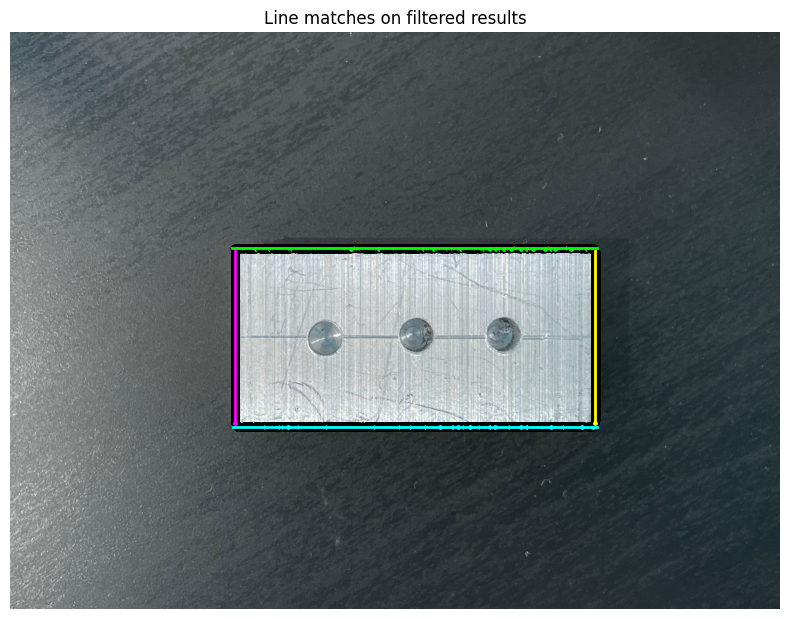

[visualize_matches] drawing feature ref=(2078.0, 1586.0, 30.0)


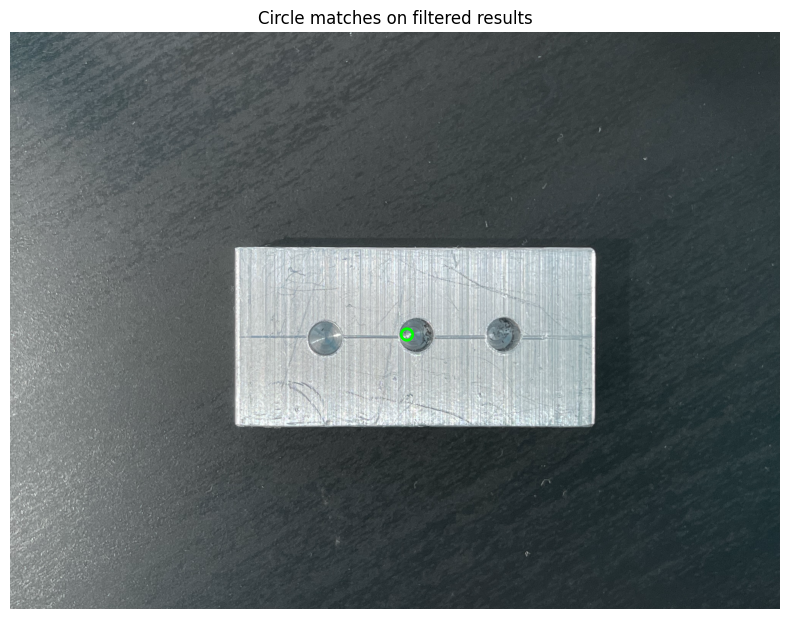

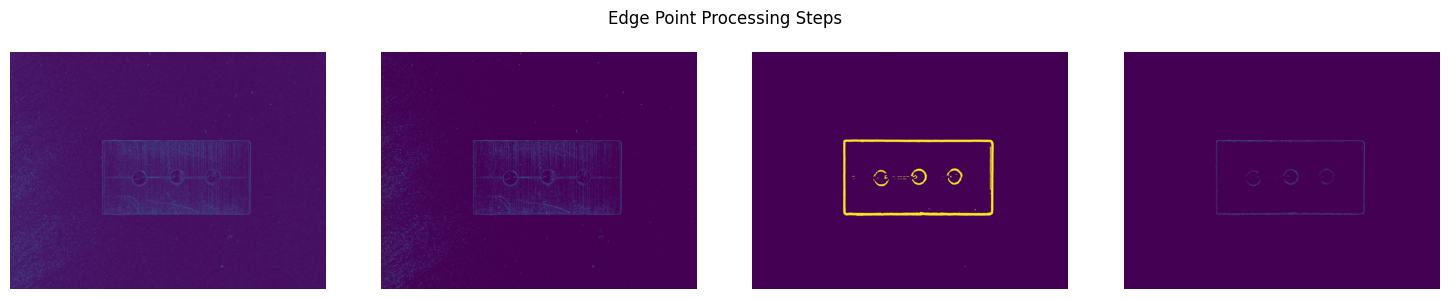

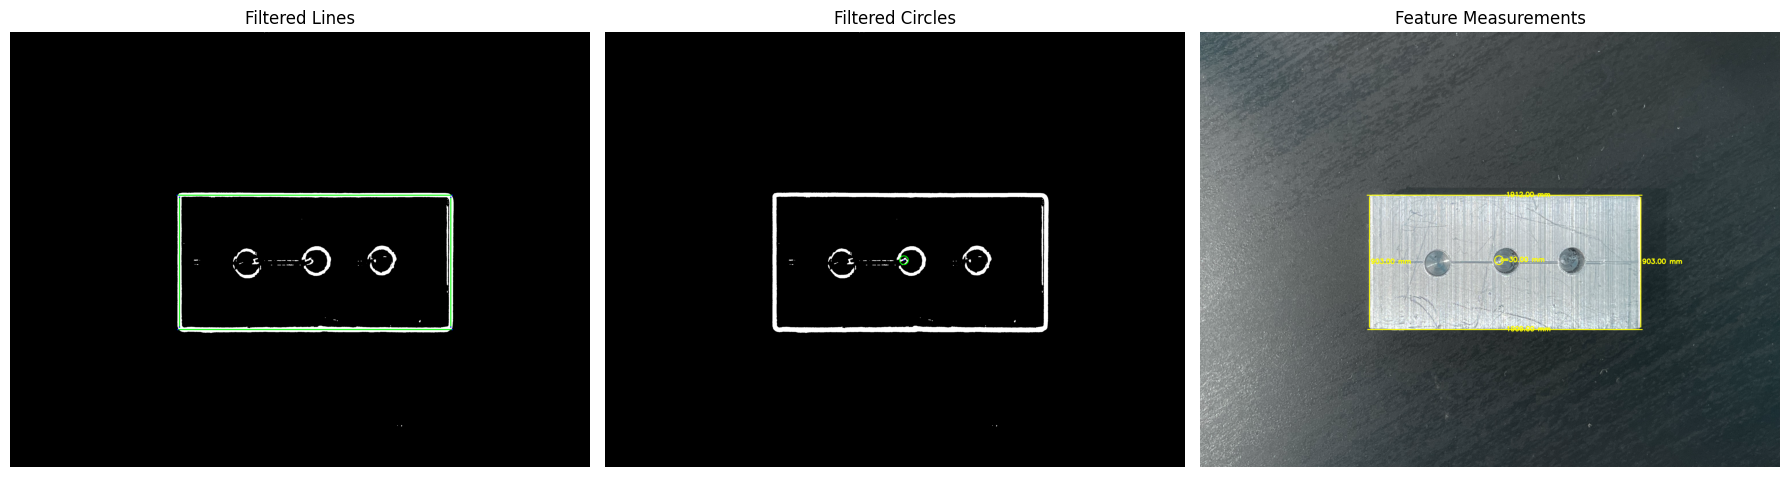

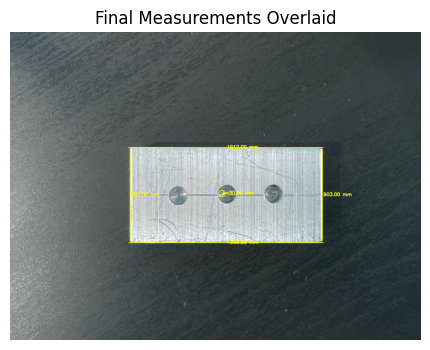

In [39]:

# Load an example image
base_path = os.getcwd()
parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in blk")
img_path = os.path.join(parts_path, "Basic II base part 2 thk0.50 r0.09375.jpeg")
#img_path = os.path.join(parts_path, "mill part 2.jpeg")
img = main.load_img(img_path, greyscale=False)

# Use consistent detection methods as specified
f_find_lines = detection.find_lines_HT
f_find_circles = detection.find_circles_HT

# Use ROI (optional) to reduce clutter
# roi = pp.crop_largest_structure(img)[0] if hasattr(pp, "crop_largest_structure") else img
# roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if roi.ndim == 3 else roi

roi = img

# 1) Preprocessing: edges
edges, interms = f_get_edges(roi, return_interm=True)

# 2) Detection (using consistent methods)
lines_raw = f_find_lines(edges)
circles_raw = f_find_circles(edges)
# Normalize circles to list for filtration
if circles_raw is None:
    circles_raw = []
elif isinstance(circles_raw, np.ndarray):
    circles_raw = circles_raw.tolist()
print("raw lines:", len(lines_raw) if lines_raw is not None else 0)
print("raw circles:", len(circles_raw))

# 3) Filtering (use detection module functions)
lines_f = f_filter_lines(lines_raw)
H, W = roi.shape[:2]
circles_f, fake_canvas = f_filter_circles(edges, circles_raw, H, W)
print("filtered lines:", len(lines_f))
print("filtered circles:", len(circles_f))

# visualization on edges
edges_gray = edges if edges.ndim==2 else cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
img_lines_final = draw_lines_circles(edges_gray, lines_f, [], thickness=5)
img_circles_final = draw_lines_circles(edges_gray, [], circles_f, thickness=5)

# 4) Matching edge points to features
edge_points, egpt_interm = pp.get_edge_points(roi, edges, return_interm=True)
line_features = match_points_to_lines(lines_f, edge_points, max_perp_dist=2.0, min_length=50.0)
circle_features = match_points_to_circles(circles_f, edge_points, max_rad_diff=4.0, min_radius=20.0)
print("line feature objects:", len(line_features))
print("circle feature objects:", len(circle_features))

# 5) Measurement using feature objects' built-in methods (matching Zack's approach)
measurement_output = roi.copy()

# Line measurements - print and draw on image (like Zack's approach)
for i, lf in enumerate(line_features):
    length = lf.measure_length()
    straightness = lf.measure_straightness()
    print(f"Line {i+1}: Length: {length:.2f}, Straightness: {straightness:.4f}")
    measurement_output = lf.draw_line_measurement(measurement_output)

# Circle measurements - print and draw on image (like Zack's approach)
for i, cf in enumerate(circle_features):
    radius = cf.measure_radius()
    circularity = cf.measure_circularity()
    print(f"Circle {i+1}: Radius: {radius:.2f}, Circularity: {circularity:.4f}")
    measurement_output = cf.draw_circle_measurement(measurement_output)

# Visualize matches using features.visualize_matches (like Zack's approach)
try:
    from features import visualize_matches
    if line_features:
        visualize_matches(roi, line_features, title='Line matches on filtered results')
    if circle_features:
        visualize_matches(roi, circle_features, title='Circle matches on filtered results', show_circle_points=False)
except ImportError:
    print("visualize_matches not available, skipping visualization")

# Show edge point processing intermediates (like Zack's approach)
if 'egpt_interm' in locals() and egpt_interm:
    plt.figure(figsize=(15, 3))
    for i, im in enumerate(egpt_interm):
        plt.subplot(1, len(egpt_interm), i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.suptitle("Edge Point Processing Steps")
    plt.tight_layout()
    plt.show()

# Show consistent visuals with Zack's measurement style
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_lines_final)
plt.title("Filtered Lines")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_circles_final)
plt.title("Filtered Circles")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(measurement_output)
plt.title("Feature Measurements")
plt.axis('off')
plt.tight_layout()
plt.show()

# Display final measurement output
plt.figure(figsize=(8, 4))
plt.imshow(measurement_output)
plt.title("Final Measurements Overlaid")
plt.axis('off')
plt.show()

# 8. End-to-End Pipeline: All Images


Processing image 1
specified part height: 0.5
specified radius in px: (89,)
raw lines: 135
raw circles: 10
filtered lines: 4
filtered circles: 3
[match_points_to_lines] detected_lines: 4, min_length: 50.0
  line ref=(1161.0,1134.0,3073.0,1134.0) len=1912.0 matched=6847
  line ref=(1165.0,2068.0,3074.0,2068.0) len=1909.0 matched=6038
  line ref=(1178.0,1148.0,1178.0,2051.0) len=903.0 matched=3126
  line ref=(3064.0,1148.0,3064.0,2051.0) len=903.0 matched=4329
[match_points_to_lines] returning features: 4
[match_points_to_circles] detected_circles: 3, min_radius: 20.0
  circle ref=(2594.0,1574.0,r=89.0) matched=558
  circle ref=(2137.0,1605.0,r=89.0) matched=1235
  circle ref=(1644.0,1619.0,r=93.0) matched=1000
[match_points_to_circles] returning features: 3
line feature objects: 4
circle feature objects: 3
Line 1: Length: 2.00, Straightness: 0.0014
Line 2: Length: 2.00, Straightness: 0.0015
Line 3: Length: 0.95, Straightness: 0.0013
Line 4: Length: 0.95, Straightness: 0.0015
Circle 1: 

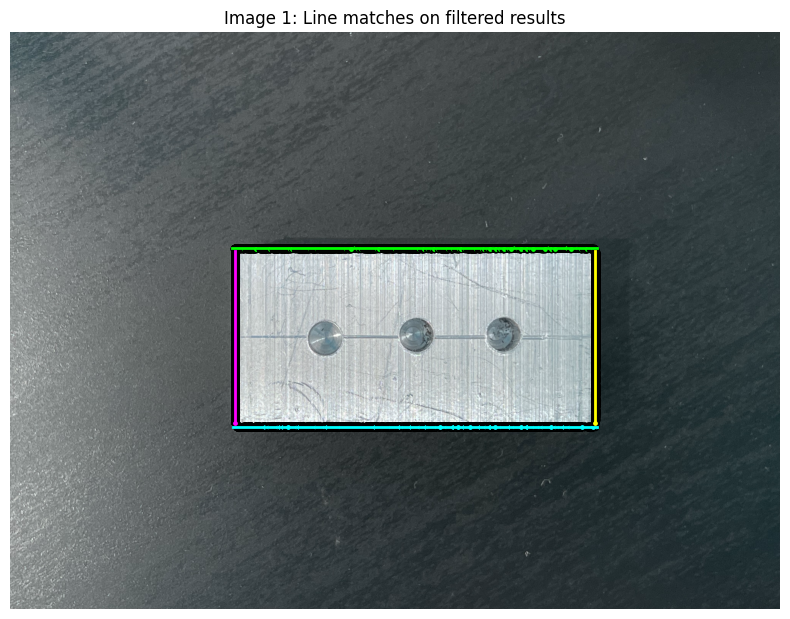

[visualize_matches] drawing feature ref=(2594.0, 1574.0, 89.0)
[visualize_matches] drawing feature ref=(2137.0, 1605.0, 89.0)
[visualize_matches] drawing feature ref=(1644.0, 1619.0, 93.0)


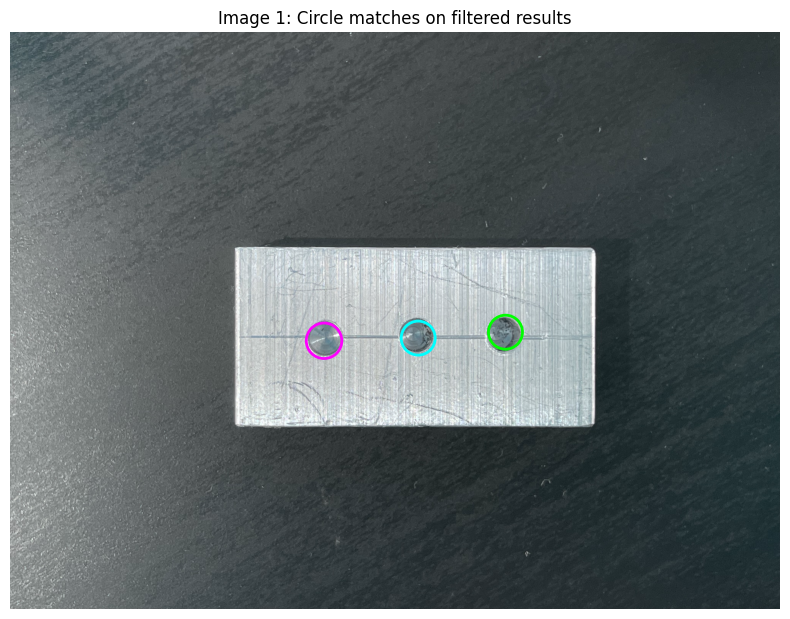

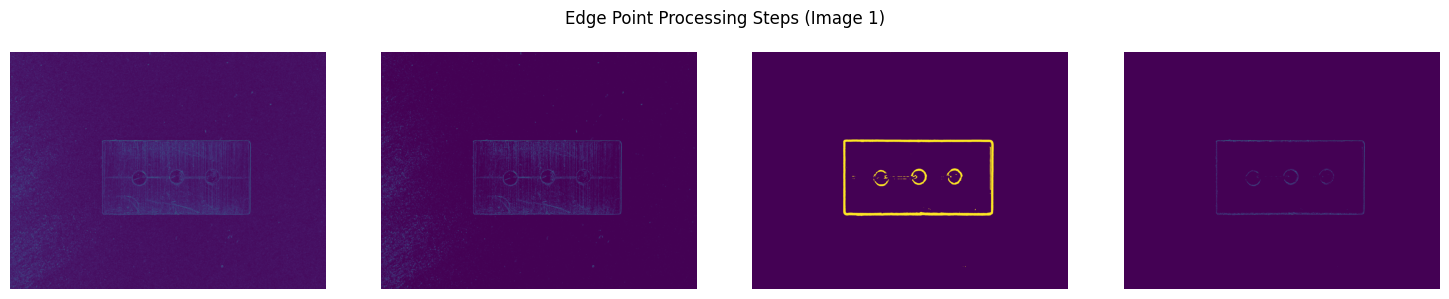

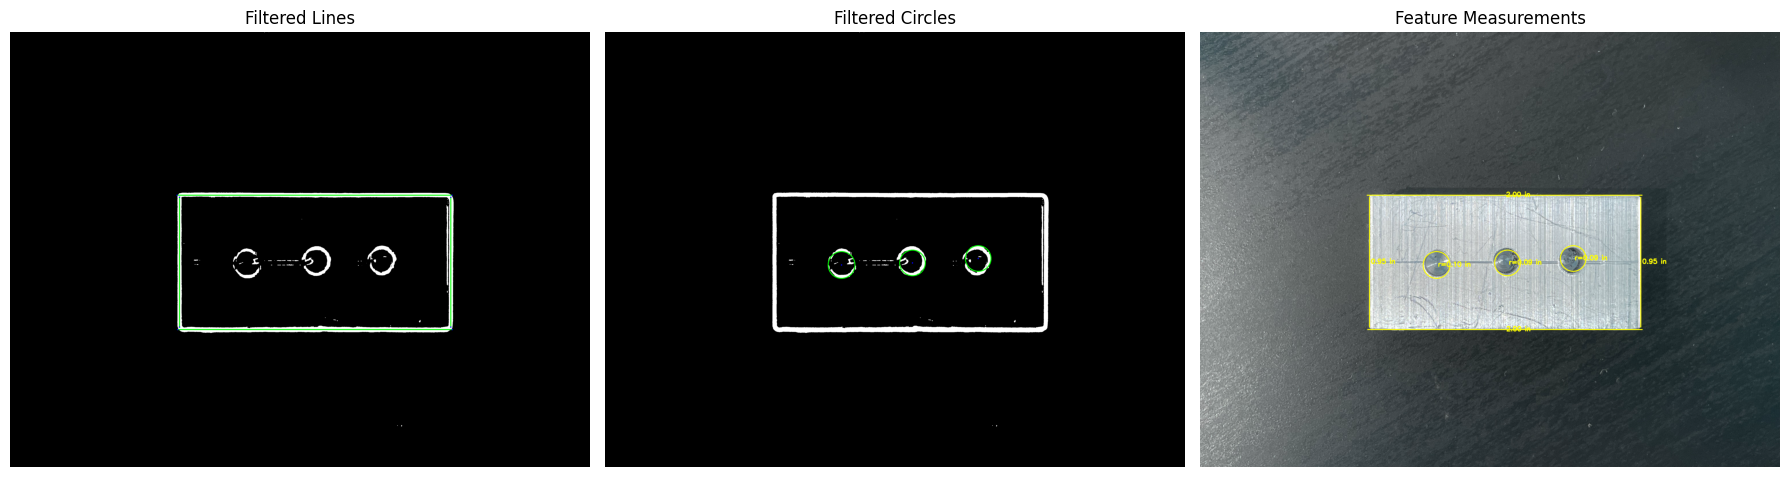

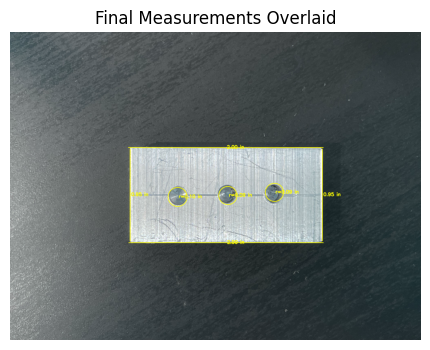


Processing image 2
specified part height: 0.5
specified radius in px: (119, 149)
raw lines: 130
raw circles: 12
filtered lines: 7
filtered circles: 3
[match_points_to_lines] detected_lines: 7, min_length: 50.0
  line ref=(1262.0,750.0,3114.0,1143.0) len=1893.2 matched=4520
  line ref=(976.0,2126.0,2817.0,2517.0) len=1882.1 matched=4272
  line ref=(3110.0,1142.0,2819.0,2516.0) len=1404.5 matched=3772
  line ref=(1274.0,747.0,981.0,2121.0) len=1404.9 matched=2349
  line ref=(2682.0,1036.0,2382.0,2442.0) len=1437.6 matched=1116
  line ref=(1259.0,750.0,1062.0,1679.0) len=949.7 matched=265
  line ref=(1554.0,2268.0,2369.0,2441.0) len=833.2 matched=99
[match_points_to_lines] returning features: 7
[match_points_to_circles] detected_circles: 3, min_radius: 20.0
  circle ref=(2035.0,1774.0,r=118.0) matched=901
  circle ref=(1638.0,1331.0,r=117.0) matched=1217
  circle ref=(2085.0,1415.0,r=146.0) matched=1176
[match_points_to_circles] returning features: 3
line feature objects: 7
circle featur

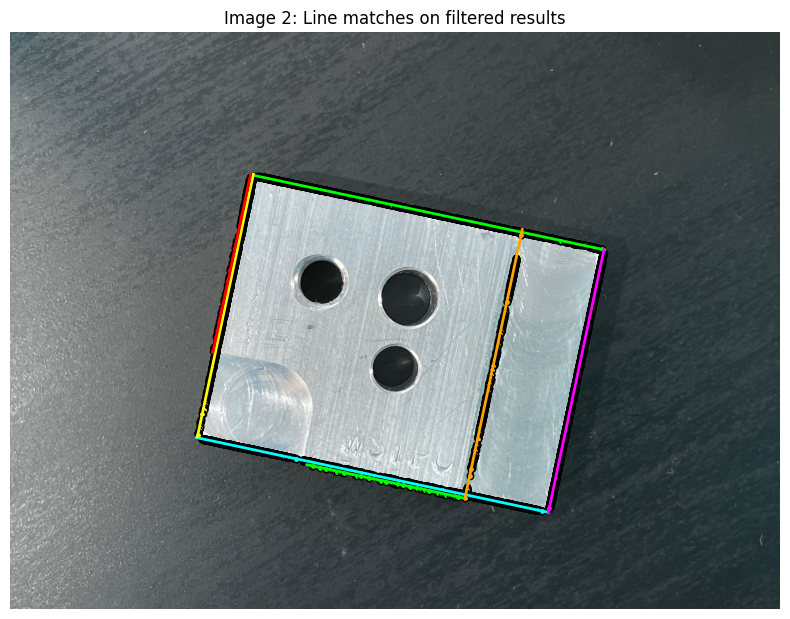

[visualize_matches] drawing feature ref=(2035.0, 1774.0, 118.0)
[visualize_matches] drawing feature ref=(1638.0, 1331.0, 117.0)
[visualize_matches] drawing feature ref=(2085.0, 1415.0, 146.0)


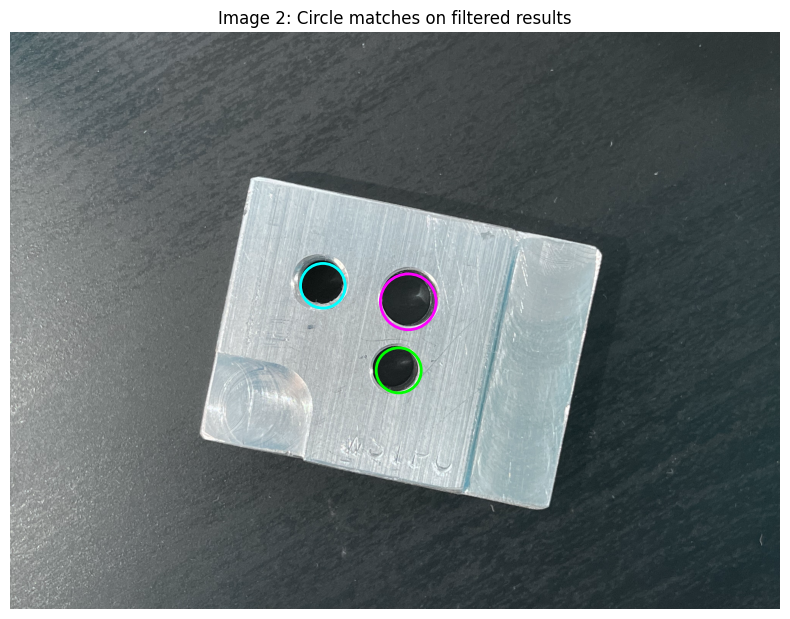

In [40]:
# ============================================
# Full pipeline function + run on all images
# ============================================

def process_image_full(
    img,
    img_index=None,
    crop=False,
    max_perp_dist=2.0,
    min_line_length=50.0,
    max_rad_diff=4.0,
    min_radius=20.0,
    px2in=2.1538/1909      # this is the px2in ratio when measurement plane is 7in from camera (was 2.1538/1909)
):
    """
    Run full detection + filtration + feature matching + measurement +
    visualization on a single image.

    This is structured to match the example "Basic II base part" cell,
    including the final 'Final Measurements Overlaid' plot which ALWAYS runs.
    """

    if img_index is not None:
        print("\n" + "=" * 80)
        print(f"Processing image {img_index}")
        print("=" * 80)

    # if img is a string (file path), load it & calculate px2in ratio from filename 
    fn = None
    rads = None
    if type(img) == str:
        # load image
        fn = img
        img = cv2.imread(fn)

        # extract part height & update px2in
        thk = re.findall(r"thk\d.\d{2}", fn)
        if thk:     # if part height identified in fn, update px2in
            thk = float(thk[0][3:])
            px2in = px2in * (7. - thk) / 7
            print("specified part height:", thk)
            

        # extract radii to search for
        rads = re.findall(r"r\d+.\d+", fn)
        rads = [float(r[1:]) for r in rads]
        rads = [int(r/px2in) for r in rads]
        rads = tuple(rads)
        print("specified radius in px:", rads)

    # Use ROI (optional) to reduce clutter
    if crop and hasattr(pp, "crop_largest_structure"):
        roi = pp.crop_largest_structure(img)[0]
    else:
        roi = img

    # roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if roi.ndim == 3 else roi

    # 1) Preprocessing: edges
    edges, interms = f_get_edges(roi, return_interm=True)

    # 2) Detection (using consistent methods)
    lines_raw = f_find_lines(edges)
    if rads:    # if there are specified radius
        circles_raw = f_find_circles(edges, R_expect=rads)
    else:
        circles_raw = f_find_circles(edges)

    # Normalize circles to list for filtration
    if circles_raw is None:
        circles_raw = []
    elif isinstance(circles_raw, np.ndarray):
        circles_raw = circles_raw.tolist()

    print("raw lines:", len(lines_raw) if lines_raw is not None else 0)
    print("raw circles:", len(circles_raw))

    # 3) Filtering (use detection module functions, like section 3/4)
    lines_f = f_filter_lines(lines_raw)
    H, W = roi.shape[:2]
    circles_f, fake_canvas = f_filter_circles(edges, circles_raw, H, W)

    print("filtered lines:", len(lines_f))
    print("filtered circles:", len(circles_f))

    # visualization on edges
    edges_gray = edges if edges.ndim == 2 else cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    img_lines_final = draw_lines_circles(edges_gray, lines_f, [], thickness=5)
    img_circles_final = draw_lines_circles(edges_gray, [], circles_f, thickness=5)

    # 4) Matching edge points to features
    edge_points, egpt_interm = pp.get_edge_points(roi, edges, return_interm=True)
    line_features = match_points_to_lines(
        lines_f,
        edge_points,
        max_perp_dist=max_perp_dist,
        min_length=min_line_length,
    )
    circle_features = match_points_to_circles(
        circles_f,
        edge_points,
        max_rad_diff=max_rad_diff,
        min_radius=min_radius,
    )
    print("line feature objects:", len(line_features))
    print("circle feature objects:", len(circle_features))

    # 5) Measurement using feature objects' built-in methods
    measurement_output = roi.copy()

    # Line measurements - print and draw on image
    for i, lf in enumerate(line_features):
        length = lf.measure_length(conversion_ratio=px2in)
        straightness = lf.measure_straightness(conversion_ratio=px2in)
        print(f"Line {i+1}: Length: {length:.2f}, Straightness: {straightness:.4f}")
        measurement_output = lf.draw_line_measurement(measurement_output, conversion_ratio=px2in, unit="in")

    # Circle measurements - print and draw on image
    for i, cf in enumerate(circle_features):
        radius = cf.measure_radius(conversion_ratio=px2in)
        circularity = cf.measure_circularity(conversion_ratio=px2in)
        print(f"Circle {i+1}: Radius: {radius:.2f}, Circularity: {circularity:.4f}")
        measurement_output = cf.draw_circle_measurement(measurement_output, conversion_ratio=px2in, unit="in")

    # Visualize matches using features.visualize_matches
    try:
        from features import visualize_matches
        if line_features:
            visualize_matches(
                roi,
                line_features,
                title=(
                    f'Image {img_index}: Line matches on filtered results'
                    if img_index is not None else 'Line matches on filtered results'
                ),
            )
        if circle_features:
            visualize_matches(
                roi,
                circle_features,
                title=(
                    f'Image {img_index}: Circle matches on filtered results'
                    if img_index is not None else 'Circle matches on filtered results'
                ),
                show_circle_points=False,
            )
    except ImportError:
        print("visualize_matches not available, skipping visualization")

    # Show edge point processing intermediates
    if egpt_interm:
        plt.figure(figsize=(15, 3))
        for i, im in enumerate(egpt_interm):
            plt.subplot(1, len(egpt_interm), i + 1)
            plt.imshow(im)
            plt.axis('off')
        title = (
            f"Edge Point Processing Steps (Image {img_index})"
            if img_index is not None
            else "Edge Point Processing Steps"
        )
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_lines_final)
    plt.title("Filtered Lines")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(img_circles_final)
    plt.title("Filtered Circles")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(measurement_output)
    plt.title("Feature Measurements")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Display final measurement output
    plt.figure(figsize=(8, 4))
    plt.imshow(measurement_output)
    plt.title("Final Measurements Overlaid")
    plt.axis('off')
    plt.show()

    return {
        "roi": roi,
        "edges": edges,
        "interms": interms,
        "fake_canvas": fake_canvas,
        "lines_raw": lines_raw,
        "circles_raw": circles_raw,
        "lines_filtered": lines_f,
        "circles_filtered": circles_f,
        "edge_points": edge_points,
        "line_features": line_features,
        "circle_features": circle_features,
        "measurement_output": measurement_output,
    }


# ============================================
# Call the function on ALL images used earlier
# ============================================

# Assumes:
#   - imgs is the list of images from earlier sections
#   - CROP is defined as before
#   - f_get_edges, f_find_lines, f_find_circles, f_filter_lines,
#     f_filter_circles, draw_lines_circles, match_points_to_lines,
#     match_points_to_circles, pp, etc. are already defined.

CROP = False

full_results = []
for idx, img in enumerate(files, start=1):
    res = process_image_full(
        img,
        img_index=idx,
        crop=CROP,
    )
    full_results.append(res)
